<font color = green>

# Logistic Regression #
</font>

<font color = green>

## Import necessary packages

</font>

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import h5py # common package to interact with a dataset that is stored on an H5 file.аз
import scipy
from PIL import Image
from scipy import ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix

<font color = green>

## Problem statement ##
</font>


Dataset ("data.h5") contains:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB) (each image is square: height = num_px and width = num_px).

Task is to build a simple image-classification algorithm that can correctly classify pictures as cat or non-cat.

<font color = green>

## Overview dataset 

</font>

<font color = green>

### Create shortcut for path

</font>

In [3]:
import os
cwd= os.getcwd() # current working directory
path = os.path.join(cwd,'data') 
# print (path)

<font color = green>

### Load dataset

</font>

In [4]:
def load_dataset():
    file_name=  os.path.join(path , 'train_catvnoncat.h5')
    train_dataset = h5py.File(file_name, "r")
    X_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    Y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels
    
    file_name=  os.path.join(path , 'test_catvnoncat.h5')
    test_dataset = h5py.File(file_name, "r")
    X_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    Y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = ['non-cat','cat']
    
    Y_train = Y_train.reshape(-1,1)
    Y_test = Y_test.reshape(-1,1)
    
    return X_train, Y_train, X_test, Y_test, classes

In [5]:
X_train,Y_train, X_test, Y_test, classes = load_dataset()
# Note : in case file not found, uncomment to print path in previous step and correct to necessary exrension

In [6]:
print ('X_train.shape= ',X_train.shape)
print ('X_test.shape= ',X_test.shape)
print ('Y_train.shape= ',Y_train.shape)
print ('Y_test.shape= ',Y_test.shape)

X_train.shape=  (209, 64, 64, 3)
X_test.shape=  (50, 64, 64, 3)
Y_train.shape=  (209, 1)
Y_test.shape=  (50, 1)


The dataset consists of labeled images of cats and non-cats:

- **m_train**: Number of training examples
- **m_test**: Number of test examples
- **num_px**: The width/height of each image (square images)

In [7]:
# YOUR_CODE.   get m_train, num_px and m_test
# START_CODE 
m_train = X_train.shape[0]  # Number of training examples
num_px = X_train.shape[1]    # Image size (height/width)
m_test = X_test.shape[0]     # Number of test examples
# END_CODE 

<font color = blue >

### Check result

</font>


In [8]:
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")


Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)


<font color = blue >

### Expected output

</font>

<br> `Number of training examples: m_train = 209` 
<br> `Number of testing examples: m_test = 50` 
<br> `Height/Width of each image: num_px = 64` 
<br> `Each image is of size: (64, 64, 3)` 



<font color = green>

### Review some examples

</font>

y = [1], it's a 'cat' picture.


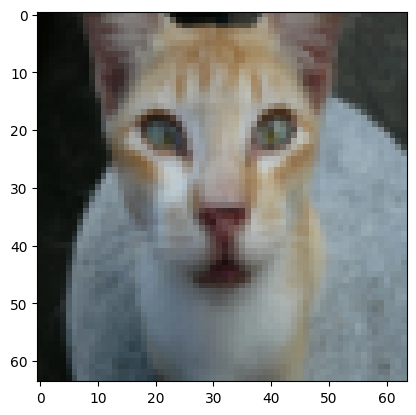

In [9]:
# Example of a picture
index = 11
plt.imshow(X_train[index])
print ("y = " + str(Y_train[index,:]) + ", it's a '" + classes[np.squeeze(Y_train[index,:])] +  "' picture.")

y = [0], it's a 'non-cat' picture.


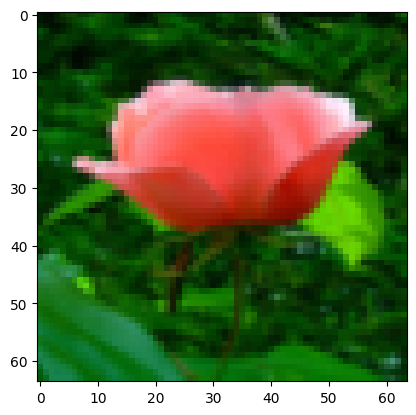

In [10]:
index = 3
plt.imshow(X_train[index])
print ("y = " + str(Y_train[index,:]) + ", it's a '" + classes[np.squeeze(Y_train[index,:])] +  "' picture.")

In [11]:
print ('Label 1 count:', np.sum(Y_train!=0))
print ('Label 0 count:', np.sum(Y_train==0))

Label 1 count: 72
Label 0 count: 137


<font color = green>

## Flatten features

</font>

### **Reshaping Formula**:
Each image has a shape of (64, 64, 3), so the flattened shape is:
$$
\text{Flattened size} = 64 \times 64 \times 3 = 12288
$$


In [10]:
# YOUR_CODE. Reshape the training and test set to shape (number_of_samples,  num_px*num_px*3)
# START_CODE 
X_train_flatten = X_train.reshape(m_train, -1)  
X_test_flatten = X_test.reshape(m_test, -1)  
# END_CODE 

<font color = blue >

### Check result

</font>


In [11]:
print ("train_set_x_flatten shape: {}".format(X_train_flatten.shape))
print ("test_set_x_flatten shape: {}".format(X_test_flatten.shape))
print ("sanity check after reshaping: {}".format(X_train_flatten[0, :5]))

train_set_x_flatten shape: (209, 12288)
test_set_x_flatten shape: (50, 12288)
sanity check after reshaping: [17 31 56 22 33]


<font color = blue >

### Expected Output

</font>


<br>`X_train_flattern shape: (209,12288)` 
<br>`X_test_flattern shape: (50,12288)`
<br>`sanity check after reshaping: [17 31 56 22 33]`


<font color = green>

## Normalize features

</font>
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

For picture datasets, it is almost the same as MinMaxScaler  to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [12]:
X_train_scaled = X_train_flatten/255.
X_test_scaled = X_test_flatten/255.

<font color = green>

## sigmoid function

</font>
The sigmoid function is defined as:

$$ g(z) = \frac{1}{1 + e^{-z}}$$

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    g -- sigmoid(z)
    """
    
    # YOUR_CODE. Implement sigmoid function
    # START_CODE 
    g = 1 / (1 + np.exp(-z))
    # END_CODE 
    
    return g

<font color = blue >

### Check result

</font>


In [14]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


<font color = blue >

### Expected Output

</font>

<br>`sigmoid([0, 2]) [0.5        0.88079708]`

<font color = green>

## Initialize parameters

</font>

To implement logistic regression, we need to initialize the parameters **w** and **b**:

- **w**: A vector of zeros with shape `(1, dim)`, where `dim` is the number of features.
- **b**: A scalar, initialized to zero.

**Formula**:
$$
w = \begin{bmatrix} 0 & 0 & \dots & 0 \end{bmatrix}, \quad b = 0
$$

In [15]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (1,dim) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (1,dim)
    b -- initialized scalar (corresponds to the bias)
    """
    
    # YOUR_CODE.  Initialize b to zero and w as a vector of zeros. 
    # START_CODE   
    w = np.zeros((1, dim))  # Create a row vector of zeros
    b = 0.0  # Initialize bias to zero
    # END_CODE 

    assert(w.shape == (1,dim))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

<font color = blue >

### Check result

</font>


In [16]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0. 0.]]
b = 0.0


<font color = blue >

### Expected Output

</font>

```
    w =  [[ 0.  0.]]
    b = 0
```

**Note**: For image inputs, w will be of shape (1, num_px $\times$ num_px $\times$ 3).

<font color = green>

##  Forward and Backward propagation

</font>


Computing cost function is called "forward" and computing derivatives (gradient) is called "backward" propagation

**Forward Propagation:**
- compute  $Z = b + X \,@\,  w.T  \quad([[z^{(0)}], [z^{(1)}], ..., [z^{(m-1)}]])$
- compute  $A = g(Z)  \quad([[a^{(0)}], [a^{(1)}], ..., [a^{(m-1)}]])$
- calculate the cost function: $J = -\frac{1}{m}\sum_{i=0}^{m-1}(y^{(i)}\log(a^{(i)})+(1-Y^{(i)})\log(1-a^{(i)}))$

**Backward Propagation:** 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}(A-Y)^T @X \quad \quad 
 \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

 1. Compute the gradient with respect to \( w \):
   $
   \frac{\partial J}{\partial w} = \frac{1}{m} (A - Y)^T X
   $

2. Compute the gradient with respect to \( b \):

   $
   \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=0}^{m-1} (a^{(i)} - y^{(i)})
   $


Compute the cost function `(adjusted based on the presentation)`:  

  $$
  J = \frac{1}{m} \sum_{i=0}^{m-1} \left( -y^{(i)} \log(h(x^{(i)})) - (1 - y^{(i)}) \log(1 - h(x^{(i)})) \right) + \frac{\lambda}{2m} \sum_{k=0}^{n-1} w_k^2
  $$

Compute the gradient `(adjusted based on the presentation)`:  
  $$
  \frac{\partial J}{\partial w} = \frac{1}{m} \sum_{i=0}^{m-1} (a^{(i)} - y^{(i)}) x_k^{(i)} + \frac{\lambda}{m} \sum_{k=0}^{n-1} w_k
  \quad (k = 0, n - 1)
  $$

   $$
   \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=0}^{m-1} (a^{(i)} - y^{(i)})
   $$


In [17]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y, C=1):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (1,num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (number of examples,1)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[0]
 
    # YOUR_CODE.  implement forward propagation 
    # START_CODE   
    Z = np.dot(X, w.T) + b  # Compute linear activation
    A = sigmoid(Z)  # Apply sigmoid activation function
    cost = - (1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) + (C / (2*m)) * np.sum(np.square(w))

    # END_CODE 
    
    # YOUR_CODE.  Implement Backward propahation 
    # START_CODE   
    dJ_dw = 1/m * np.dot((A - Y).T, X)+ (C/m) * w
    dJ_db = (1/m) * np.sum(A - Y)  # Compute gradient of b

   # END_CODE 

    assert(dJ_dw.shape == w.shape)
    assert(dJ_db.dtype == float)
    assert(cost.dtype == float)
    
    grads = {"dJ_dw": dJ_dw,
             "dJ_db": dJ_db}
    
    return grads, cost

<font color = blue >

### Check result

</font>


In [18]:
w, b, X, Y = np.array([[1., 2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]).T, np.array([[1,0,1]]).T
grads, cost = propagate(w, b, X, Y)
print ("dJ_dw = " + str(grads["dJ_dw"]))
print ("dJ_db = " + str(grads["dJ_db"]))
print ("cost = " + str(cost))

dJ_dw = [[1.33178935 3.06173906]]
dJ_db = 0.001455578136784208
cost = 6.6348786527278865


<font color = blue >

### Expected Output
</font>

``` 
dJ_dw = [[1.33178935 3.06173906]]
dJ_db = 0.001455578136784208
cost = 6.6348786527278865
```


<font color = green>

##   Optimization
</font>

The parameter update happens according to the following formulas:

$$
w = w - \alpha \cdot \frac{\partial J}{\partial w}
$$

$$
b = b - \alpha \cdot \frac{\partial J}{\partial b}
$$

where alpha is the learning rate.

In [19]:
def optimize(w, b, X, Y, num_iterations, learning_rate, C= 1, verbose = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (1,num_px * num_px * 3)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (number of examples,1)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
   
    costs = [] # keep history for plotting if necessary 
    
    for i in range(num_iterations):        

    
        # YOUR_CODE.  Call to compute cost and gradient 
        # START_CODE   
        grads, cost = propagate(w, b, X, Y, C)
        # END_CODE 
        
        # Retrieve derivatives from grads
        dJ_dw = grads["dJ_dw"]
        dJ_db = grads["dJ_db"]
        
        # YOUR_CODE.  Update paramaters 
        # START_CODE   
        w = w - learning_rate * dJ_dw
        b = b - learning_rate * dJ_db
        # END_CODE 
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if verbose and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dJ_dw": dJ_dw,
             "dJ_db": dJ_db}
    
    return params, grads, costs

<font color = blue >

### Check result

</font>


In [20]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, verbose = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dJ_dw"]))
print ("db = " + str(grads["dJ_db"]))

w = [[ 0.08006006 -0.02399336]]
b = 1.9060971483059892
dw = [[0.62090316 1.19256883]]
db = 0.2084129285706479


<font color = blue >

### Expected Output
</font>


```
w = [[ 0.08006006 -0.02399336]]
b = 1.9060971483059892
dw = [[0.62090316 1.19256883]]
db = 0.2084129285706479
```

<font color = green>

##  Predict
</font>

1. Calculate $\hat{Y} = A = g(b + X @ w.T)$
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`. Try to avoid `for loop`  but use  vectorized way if possible.

In [21]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w - weights, a numpy array of size (1,num_px * num_px * 3)
    b - bias, a scalar
    X - data of size (number of examples, num_px * num_px * 3)
    
    Returns:
    Y_prediction - a numpy array of shape (number of examples, 1) containing all predictions (0/1) for the examples in X
    '''
    m,n = X.shape
    assert (w.shape==(1,n))
 
    # YOUR_CODE.  Compute "A" predicting the probabilities of a cat being present in the picture
    # START_CODE   
    Z = np.dot(X, w.T) + b  # Linear combination
    A = sigmoid(Z)
    # END_CODE 

    # YOUR_CODE.  Convert probabilities to actual predictions 0 or 1 
    # START_CODE   
    Y_prediction = (A >= 0.5).astype(int)
    # END_CODE 
    
    assert(Y_prediction.shape == (m, 1))
    
    return Y_prediction

<font color = blue >

### Check result

</font>


In [22]:
w = np.array([[0.1124579],[0.23106775]]).T
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]]).T
print ("predictions = \n{}".format (predict(w, b, X)))

predictions = 
[[1]
 [1]
 [0]]


<font color = blue >

### Expected Output
</font>

<br>`predictions=`
<br>`[[1]`
<br>` [1]`
<br>` [0]]`



<font color = green>

##   Model
</font>



In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, verbose = False, C= 1):
    """
    Builds the logistic regression model by calling the functions implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (number of examples, num_px * num_px * 3)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (number of examples,1)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    C- regularization parameter 
    
    Returns:
    res -- dictionary containing information about the model.
    """
    
    # YOUR_CODE.
    # START_CODE   

    #  initialize parameters
    dim = X_train.shape[1]
    w, b = initialize_with_zeros(dim)
    
    # run gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, C, verbose)

    # retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # predict test/train set examples
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    # END_CODE 

    # Print train/test Errors
    print("train accuracy= {:.3%}".format(np.mean(Y_prediction_train == Y_train)))
    print("test accuracy= {:.3%}".format(np.mean(Y_prediction_test == Y_test)))
    
    res = {'costs': costs,
           'Y_prediction_test': Y_prediction_test, 
           'Y_prediction_train' : Y_prediction_train, 
           'w' : w, 
           'b' : b,
           'learning_rate' : learning_rate,
           'num_iterations': num_iterations,
           'C':C
          }
    
    return res

<font color = blue >

### Check result

</font>


In [24]:
res = model(X_train= X_train_scaled,
            Y_train=Y_train, 
            X_test=X_test_scaled, 
            Y_test= Y_test, 
            num_iterations = 3000, 
            learning_rate = 0.005, 
            verbose = True,
            C= 0.3 # 0.6 is still overfitting,   0.3  is low value to keep the test accuracy ashigh as possible
           )

[[0. 0. 0. ... 0. 0. 0.]]
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584629
Cost after iteration 200: 0.467312
Cost after iteration 300: 0.376600
Cost after iteration 400: 0.332075
Cost after iteration 500: 0.304082
Cost after iteration 600: 0.280889
Cost after iteration 700: 0.261253
Cost after iteration 800: 0.244354
Cost after iteration 900: 0.229618
Cost after iteration 1000: 0.216632
Cost after iteration 1100: 0.205088
Cost after iteration 1200: 0.194749
Cost after iteration 1300: 0.185431
Cost after iteration 1400: 0.176986
Cost after iteration 1500: 0.169295
Cost after iteration 1600: 0.162262
Cost after iteration 1700: 0.155806
Cost after iteration 1800: 0.149859
Cost after iteration 1900: 0.144365
Cost after iteration 2000: 0.139273
Cost after iteration 2100: 0.134543
Cost after iteration 2200: 0.130138
Cost after iteration 2300: 0.126027
Cost after iteration 2400: 0.122182
Cost after iteration 2500: 0.118579
Cost after iteration 2600: 0.115196
Cost after ite

<font color = blue >

### Expected Output
</font>

```
...
Cost after iteration 2600: 0.057748
Cost after iteration 2700: 0.056804
Cost after iteration 2800: 0.055918
Cost after iteration 2900: 0.055084
train accuracy= 98.565%
test accuracy= 70.000%
```

<font color = green>

##  Visualize cost function changes 
</font>



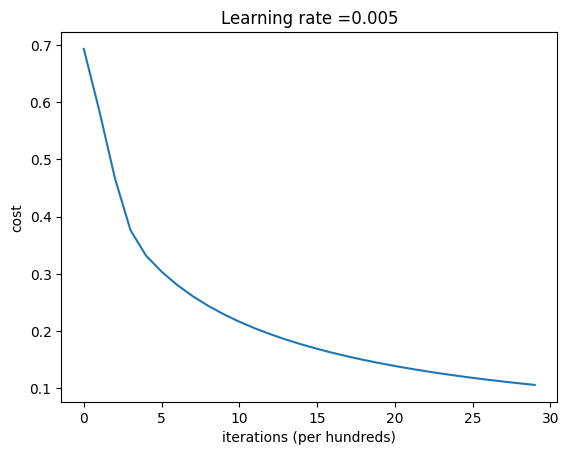

In [25]:
costs = np.squeeze(res['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(res["learning_rate"]))
plt.show()

<font color = green>

##   Visualize prediction
</font>



#### Steps taken to process and predict images from a directory using the trained model with weights (`res["w"]`) and bias (`res["b"]`).

Step 1: Load image files and preprocess each image
- Define the path to the folder containing images.
- List all `.jpg` files in the directory.
- Open each image file.
- Resize it to `(num_px, num_px)`.
- Convert it into a numpy array.
- Keep only the first 3 channels (RGB).
- Flatten the image into a 1D array.

Step 2: Predict Using the Trained Model
- Use the trained model parameters (`w`, `b`) to make a prediction.
- Convert the prediction into a binary output (`1 = cat`, `0 = not a cat`).

Step 3: Evaluate the Prediction
- Check if the filename contains `"cat"`.
- Compare the filename with the model's prediction.
- If correct, output `1`, otherwise output `0`.

**Example:**
| Filename          | Model Prediction | Expected Result | Correct ? |
|------------------|-----------------|----------------|----------|
| `img_cat1.jpg`     | `1 (Cat)`        | ✔ Cat         | ✔ `1`   |
| `img_dog2.jpg`     | `0 (Not a Cat)`  | ✔ Not a Cat   | ✔ `1`   |
| `img_cat2.jpg`     | `0 (Not a Cat)`  | ✖ Cat         | ✖ `0`   |
| `img_rabbit5.jpg`  | `1 (Cat)`        | ✖ Not a Cat   | ✖ `0`   |


`Step 1:` Load image file and preprocess image

In [26]:
def load_and_preprocess_image(file_name, num_px):
    """ 
    Loads an image, resizes it to (num_px, num_px), and converts it to a 1D numpy array.
    
    Args:
        file_name (str): Path to the image file.
        num_px (int): The desired size for resizing the image.
    
    Returns:
        np.array: The processed image as a flattened numpy array.
        Image: The original resized image (for displaying).
    """
    image = Image.open(file_name).resize((num_px, num_px))
    image_array = np.array(image.getdata())[:, :3]  # Keep only RGB channels if there are 4
    image_array = image_array.reshape((1, num_px * num_px * 3))  # Flatten the image
    return image_array, image


`Step 2:` Predict Using the Trained Model

In [27]:
def predict_image(image_array, model_weights, model_bias):
    """
    Predicts the class of an image using the trained model.
    
    Args:
        image_array (np.array): Flattened image array.
        model_weights (np.array): Trained model weights.
        model_bias (float): Trained model bias.
    
    Returns:
        int: The predicted class (1 for cat, 0 for non-cat).
    """
    return np.squeeze(predict(model_weights, model_bias, image_array))


`Step 3:` Evaluate the Prediction

In [28]:
def evaluate_prediction(image_file, is_cat):
    """
    Evaluates whether the model's prediction is correct based on the filename.
    
    Args:
        image_file (str): The filename of the image.
        is_cat (int): The predicted class (1 for cat, 0 for non-cat).
    
    Returns:
        int: 1 if the prediction is correct, 0 otherwise.
    """
    return 1 if (is_cat == 1 and 'cat' in image_file) or (is_cat == 0 and 'cat' not in image_file) else 0


Processes all images in a folder: loads, predicts, evaluates, and displays them.

In [41]:
def process_images(path, num_px, model_weights, model_bias):
    """
    Processes all images in a folder: loads, predicts, evaluates, and displays them.
    
    Args:
        path (str): Path to the folder containing images.
        num_px (int): Target image size for resizing.
        model_weights (np.array): Trained model weights.
        model_bias (float): Trained model bias.
    """
    image_files = [f for f in os.listdir(path) if f.endswith('.jpg')]

    for image_file in image_files:
        file_name = os.path.join(path, image_file)

        # Load and preprocess the image
        image_array, image = load_and_preprocess_image(file_name, num_px)

        # Predict the image class
        is_cat = predict_image(image_array, model_weights, model_bias)
        print(f'Processing {image_file}')
        print(f'y = {is_cat}, your algorithm predicts a {classes[is_cat]} picture.')

        # Evaluate prediction correctness
        correctness = evaluate_prediction(image_file, is_cat)
        print(f"Prediction for {image_file}: {correctness} ({'correct' if correctness == 1 else 'incorrect'})")

        # Display the image with the prediction result
        plt.imshow(image)
        plt.title(f"Prediction: {classes[is_cat]}")
        plt.show()



C:\Users\User\AppData\Local\Temp\ipykernel_18008\2806967689.py:14: RuntimeWarning: overflow encountered in exp
  g = 1 / (1 + np.exp(-z))


Processing img_cat1.jpg
y = 0, your algorithm predicts a non-cat picture.
Prediction for img_cat1.jpg: 0 (incorrect)


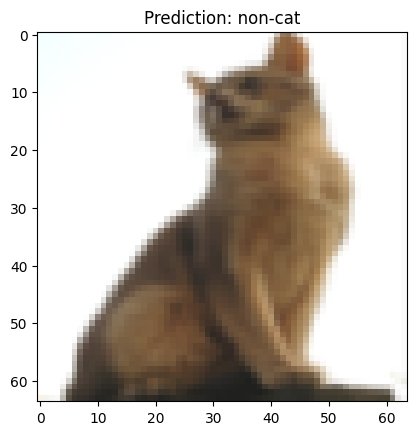

Processing img_cat2.jpg
y = 1, your algorithm predicts a cat picture.
Prediction for img_cat2.jpg: 1 (correct)


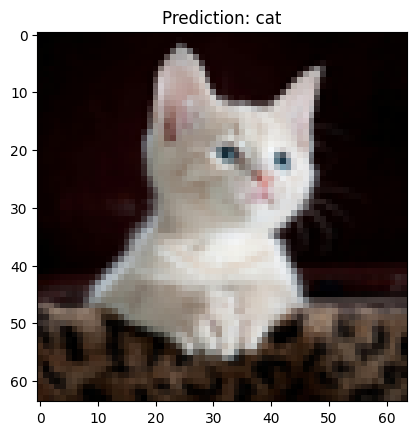

Processing img_cat3.jpg
y = 1, your algorithm predicts a cat picture.
Prediction for img_cat3.jpg: 1 (correct)


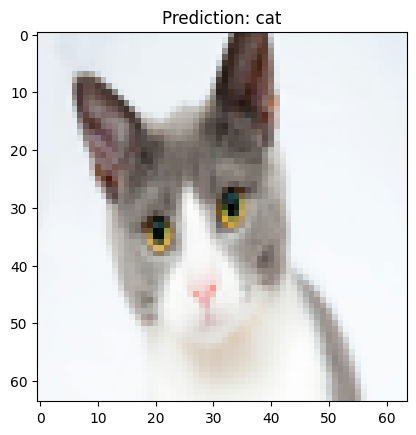

Processing img_cat4.jpg
y = 0, your algorithm predicts a non-cat picture.
Prediction for img_cat4.jpg: 0 (incorrect)


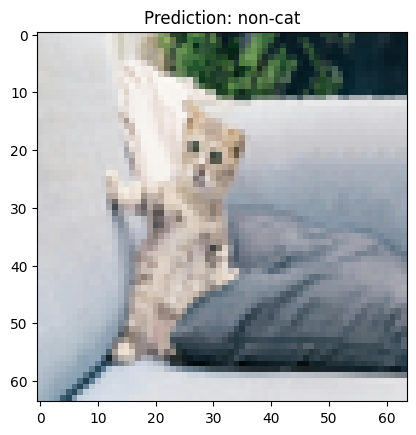

Processing img_cat5.jpg
y = 1, your algorithm predicts a cat picture.
Prediction for img_cat5.jpg: 1 (correct)


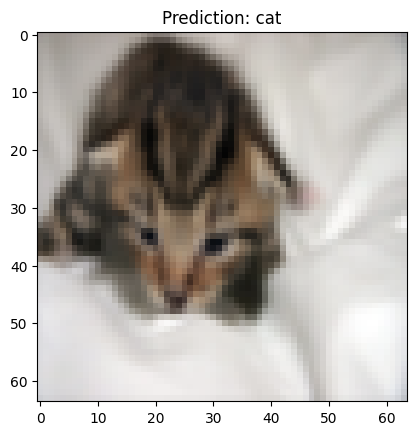

Processing img_cat_brawl_stars.jpg
y = 1, your algorithm predicts a cat picture.
Prediction for img_cat_brawl_stars.jpg: 1 (correct)


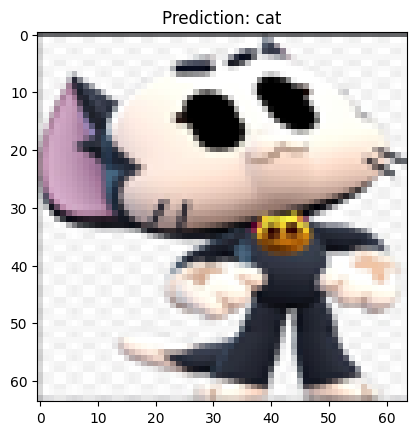

Processing img_spike_brawl_stars.jpg
y = 0, your algorithm predicts a non-cat picture.
Prediction for img_spike_brawl_stars.jpg: 1 (correct)


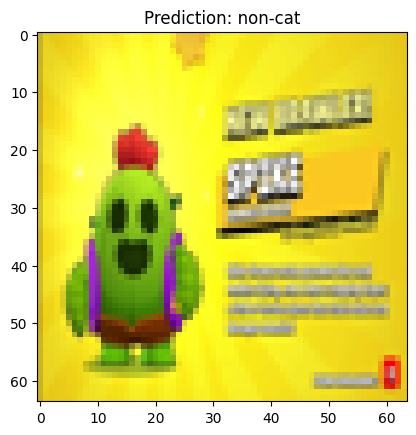

Processing img_test.jpg
y = 0, your algorithm predicts a non-cat picture.
Prediction for img_test.jpg: 1 (correct)


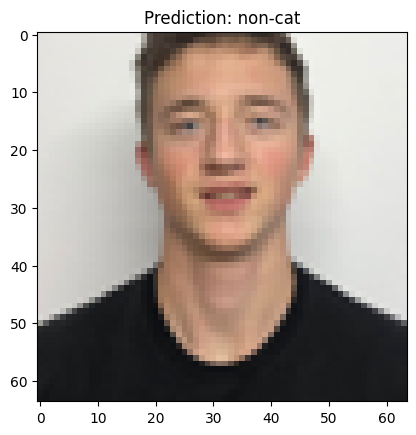

Processing Oleksiy.Tsebriy.jpg
y = 0, your algorithm predicts a non-cat picture.
Prediction for Oleksiy.Tsebriy.jpg: 1 (correct)


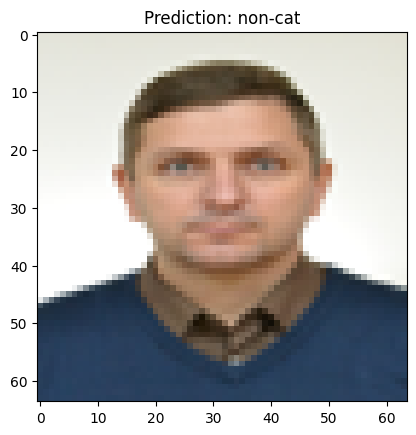

In [42]:
path = os.path.join(cwd, 'data', 'images')
process_images(path, num_px, res["w"], res["b"])

<font color = green>

##  Sklearn implementation
</font>

Load and preprocess image 

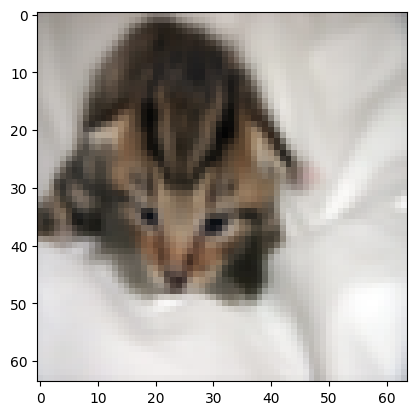

In [40]:
file_name=  os.path.join(cwd,'data' ,'images', 'img_cat5.jpg')
image_array, image =load_and_preprocess_image(file_name,num_px)
plt.imshow(image)

Train Logistic regression model

In [48]:
from sklearn.linear_model import LogisticRegression

y_train = np.squeeze(Y_train) # LogisticRegression requires 1d input for y
clf = LogisticRegression(C=0.01).fit(X_train_scaled, y_train)

 Evaluate model performance

In [49]:
print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
y_test = np.squeeze(Y_test)
print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))

train accuracy= 90.909%
test accuracy= 66.000%


Make a prediction

In [50]:
print('y = {} , sklearn algorithm predicts a {} picture.'.
      format(np.squeeze(clf.predict(image_array)),classes[np.squeeze(clf.predict(image_array))]))

y = 1 , sklearn algorithm predicts a cat picture.


### Confusion Matrix Analysis for `Test Images`

The confusion matrix below evaluates the performance of our **cat vs non-cat** classifier on the **test images**.

C:\Users\User\AppData\Local\Temp\ipykernel_18008\2806967689.py:14: RuntimeWarning: overflow encountered in exp
  g = 1 / (1 + np.exp(-z))


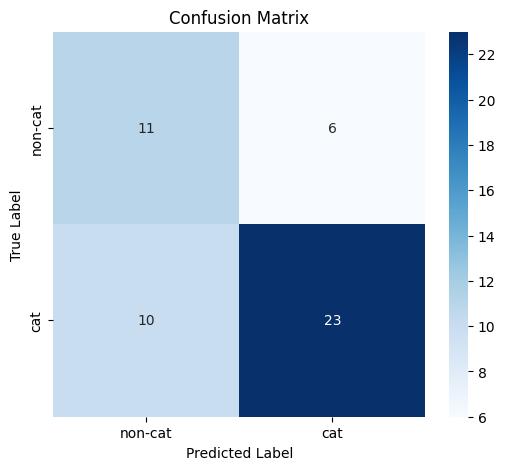

In [44]:
# Predict the labels for the test dataset
y_pred = np.array([predict_image(x.reshape(1, -1), res["w"], res["b"]) for x in X_test_flatten])
# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Visualization of the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Interpretation of the Confusion Matrix:
- **True Negative (TN) = 11** -> Non-cat images correctly classified as non-cat.
- **False Positive (FP) = 6**  -> Non-cat images misclassified as cat.
- **False Negative (FN) = 10** -> Cat images misclassified as non-cat.
- **True Positive (TP) = 23**  -> Cat images correctly classified as cat.

Observations:
- The model correctly identified `23 out of 33 cats` (~70% accuracy for cats).
- The model correctly identified `11 out of 17 non-cats` (~65% accuracy for non-cats).

<font color = green>

##  Sklearn for brest cancer dataset 
</font>



In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer

# Load the breast cancer dataset
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target

# Split data into training and test sets using random_state = 0
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state=0)

#  train LogisticRegression classifier  for max_iter= 10000
clf = LogisticRegression(max_iter=10000).fit(X_train, y_train)

print('\nBreast cancer dataset')
print ('X_cancer.shape= {}'.format(X_cancer.shape))
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))


Breast cancer dataset
X_cancer.shape= (569, 30)
Accuracy of Logistic regression classifier on training set: 0.96
Accuracy of Logistic regression classifier on test set: 0.95


<font color = blue >

### Expected Output
</font>

```

Breast cancer dataset
X_cancer.shape= (569, 30)
Accuracy of Logistic regression classifier on training set: 0.96
Accuracy of Logistic regression classifier on test set: 0.95
```

<font color = green>

##  Sklearn for synthetic dataset 
</font>



<font color = green>

###  Additional functions for visualization
</font>



In [348]:
%matplotlib notebook

In [52]:
def plot_decision_boundary(clf, X_train, y_train, X_test=None, y_test= None, title=None, precision=0.01,plot_symbol_size = 50, ax= None,  is_extended=True):

    '''    
    Draws the binary decision boundary for X that is nor required additional features and transformation (like polynomial)
    '''
    # Create color maps - required by pcolormesh
    from matplotlib.colors import  ListedColormap
    colors_for_points = np.array(['grey', 'orange']) # neg/pos
    colors_for_areas = np.array(['grey', 'orange']) # neg/pos  # alpha is applied later 
    cmap_light = ListedColormap(colors_for_areas)
    

 
    
    mesh_step_size = precision #.01  # step size in the mesh
    if X_test is None or y_test is None:
        show_test= False
        X= X_train
    else:
        show_test= True
        X= np.concatenate([X_train,X_test], axis=0)
    x1_min, x1_max = X[:, 0].min() - .1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - .1, X[:, 1].max() + 0.1
    # Create grids of pairs
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, mesh_step_size),
                         np.arange(x2_min, x2_max, mesh_step_size))
    # Flatten all samples 
    target_samples_grid= (np.c_[xx1.ravel(), xx2.ravel()])

    print ('Call prediction for all grid values (precision of drawing = {},\n you may configure to speed up e.g. precision=0.05)'.format(precision))
    Z = clf.predict(target_samples_grid)

    # Reshape the result to original meshgrid shape 
    Z = Z.reshape(xx1.shape)
    
    if ax:
        plt.sca(ax)
    
    # Plot all meshgrid prediction      
    plt.pcolormesh(xx1, xx2,Z, cmap = cmap_light, alpha=0.2)

    # Plot train set
    plt.scatter(X_train[:, 0], X_train[:, 1], s=plot_symbol_size, 
                c=colors_for_points[y_train.ravel()], edgecolor = 'black',alpha=0.6)
    # Plot test set
    if show_test:
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='^', s=plot_symbol_size, 
                c=colors_for_points[y_test.ravel()],edgecolor = 'black',alpha=0.6)
    if  is_extended:
        # Create legend  
        import matplotlib.patches as mpatches # use to assign lavels for colored points 
        patch0 = mpatches.Patch(color=colors_for_points[0], label='negative')
        patch1 = mpatches.Patch(color=colors_for_points[1], label='positive')
        plt.legend(handles=[patch0, patch1])
    plt.title(title)
    if is_extended:
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
    else:
        plt.tick_params(
        top =False,
        bottom= False,
        left  = False,
        labelleft = False, 
        labelbottom = False
        )

   
    
def plot_data_logistic_regression(X,y,legend_loc= 1, title= None):
    '''
    :param X: 2 dimensional ndarray
    :param y:  1 dimensional ndarray. Use y.ravel() if necessary
    :return:
    '''

    positive_indices = (y == 1)
    negative_indices = (y == 0)
#     import matplotlib as mpl
    colors_for_points = ['grey', 'orange'] # neg/pos

    plt.scatter(X[negative_indices][:,0], X[negative_indices][:,1], s=40, c=colors_for_points [0], edgecolor = 'black', label='negative', alpha = 0.7)
    plt.scatter(X[positive_indices][:,0], X[positive_indices][:,1], s=40, c=colors_for_points [1], edgecolor = 'black',label='positive', alpha = 0.7)
    plt.title(title)
    plt.legend(loc= legend_loc)



<font color = green>

###  Make classification
</font>



In [53]:
from sklearn.datasets import make_classification
Xc_2, yc_2= make_classification(n_samples=100,
                                n_features=2,
                                n_informative=2,
                                n_redundant=0,
                                random_state=2018,
                                n_clusters_per_class=1,
                                flip_y = 0.1,
                                class_sep = 0.8)



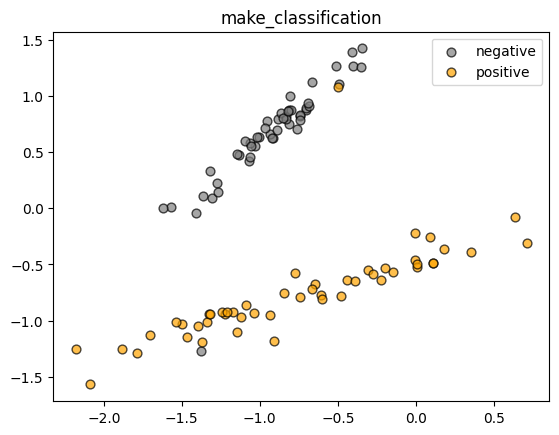

In [54]:
plt.figure()    
plot_data_logistic_regression(Xc_2,yc_2,title= 'make_classification')


In [55]:
C = 1000
X_train, X_test, y_train, y_test = train_test_split(Xc_2, yc_2, random_state = 0)
clf = LogisticRegression(C=C).fit(X_train, y_train)
print('Make Regression')
print ('Xc_2.shape= {}'.format(Xc_2.shape))
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Make Regression
Xc_2.shape= (100, 2)
Accuracy of Logistic regression classifier on training set: 0.99
Accuracy of Logistic regression classifier on test set: 0.92


Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)


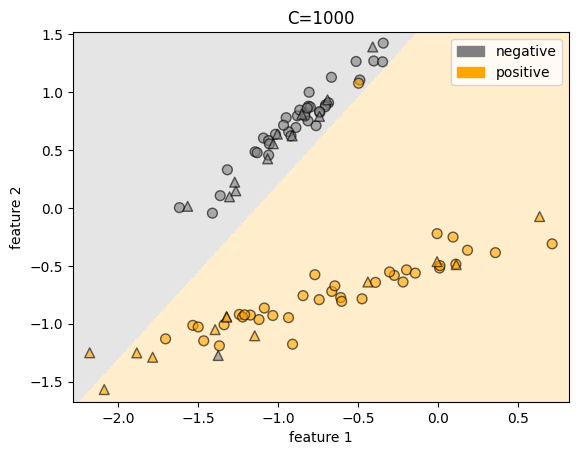

In [56]:
plt.figure()    
plot_decision_boundary(clf, X_train, y_train, X_test, y_test, title='C={}'.format(C),precision=0.01, plot_symbol_size = 50)


Accuracy = 0.57
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.97
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.99
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.99
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.99
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)
Accuracy = 0.99
Call prediction for all grid values (precision of drawing = 0.01,
 you may configure to speed up e.g. precision=0.05)


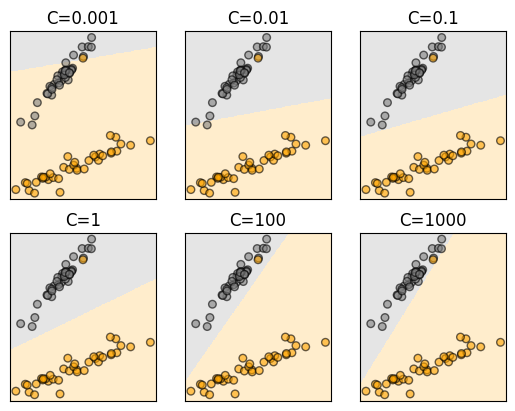

In [57]:
_, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
axes = (ax1, ax2, ax3, ax4, ax5, ax6)
C = (0.001, 0.01, 0.1, 1, 100, 1000)
for i in range (len(C)):    
    clf = LogisticRegression(C=C[i]).fit(X_train, y_train)
    print('Accuracy = {:.2f}'.format(clf.score(X_train, y_train)))

    plot_decision_boundary(clf, X_train, y_train, title='C={}'.format(C[i]),precision=0.01, plot_symbol_size = 30, ax= axes[i], is_extended=False)
    

<font color = green>

## Polynomial In Logistic Regression

</font>

In [54]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

<font color = green>

###  Additional functions for visualization
</font>



In [356]:
%matplotlib notebook

In [59]:
def plot_decision_boundary(clf, X_train, y_train, X_test=None, y_test= None, title=None, precision=0.05,plot_symbol_size = 50, ax= None,  is_extended=True):

    '''    
    Draws the binary decision boundary for X that is nor required additional features and transformation (like polynomial)
    '''
    # Create color maps - required by pcolormesh
    from matplotlib.colors import  ListedColormap
    colors_for_points = np.array(['grey', 'orange']) # neg/pos
    colors_for_areas = np.array(['grey', 'orange']) # neg/pos  # alpha is applied later 
    cmap_light = ListedColormap(colors_for_areas)
    

 
    
    mesh_step_size = precision #.01  # step size in the mesh
    if X_test is None or y_test is None:
        show_test= False
        X= X_train
    else:
        show_test= True
        X= np.concatenate([X_train,X_test], axis=0)
    x1_min, x1_max = X[:, 0].min() - .1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - .1, X[:, 1].max() + 0.1
    # Create grids of pairs
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, mesh_step_size),
                         np.arange(x2_min, x2_max, mesh_step_size))
    # Flatten all samples 
    target_samples_grid= (np.c_[xx1.ravel(), xx2.ravel()])

    print ('Call prediction for all grid values (precision of drawing = {},\n you may configure to speed up e.g. precision=0.05)'.format(precision))
    Z = clf.predict(target_samples_grid)

    # Reshape the result to original meshgrid shape 
    Z = Z.reshape(xx1.shape)
    
    if ax:
        plt.sca(ax)
    
    # Plot all meshgrid prediction      
    plt.pcolormesh(xx1, xx2,Z, cmap = cmap_light, alpha=0.2)

    # Plot train set
    plt.scatter(X_train[:, 0], X_train[:, 1], s=plot_symbol_size, 
                c=colors_for_points[y_train.ravel()], edgecolor = 'black',alpha=0.6)
    # Plot test set
    if show_test:
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='^', s=plot_symbol_size, 
                c=colors_for_points[y_test.ravel()],edgecolor = 'black',alpha=0.6)
    if  is_extended:
        # Create legend  
        import matplotlib.patches as mpatches # use to assign lavels for colored points 
        patch0 = mpatches.Patch(color=colors_for_points[0], label='negative')
        patch1 = mpatches.Patch(color=colors_for_points[1], label='positive')
        plt.legend(handles=[patch0, patch1])
    plt.title(title)
    if is_extended:
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
    else:
        plt.tick_params(
        top =False,
        bottom= False,
        left  = False,
        labelleft = False, 
        labelbottom = False
        )

def plot_decision_boundary_poly(clf, X_train, y_train, degree, X_test=None, y_test= None, title=None, precision=0.05,plot_symbol_size = 50, ax= None,  is_extended=True):

    '''    
    Draws the binary decision boundary for X that is nor required additional features and transformation (like polynomial)
    '''
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree,include_bias=False)
    
    # Create color maps - required by pcolormesh
    from matplotlib.colors import  ListedColormap    
    colors_for_points = np.array(['grey', 'orange']) # neg/pos
    colors_for_areas = np.array(['grey', 'orange']) # neg/pos  # alpha is applied later 
    cmap_light = ListedColormap(colors_for_areas)
    

 
    
    mesh_step_size = precision #.01  # step size in the mesh
    if X_test is None or y_test is None:
        show_test= False
        X= X_train
    else:
        show_test= True
        X= np.concatenate([X_train,X_test], axis=0)
    x1_min, x1_max = X[:, 0].min() - .1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - .1, X[:, 1].max() + 0.1
    # Create grids of pairs
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, mesh_step_size),
                         np.arange(x2_min, x2_max, mesh_step_size))
    # Flatten all samples 
    target_samples_grid= (np.c_[xx1.ravel(), xx2.ravel()])
    target_samples_grid_poly = poly.fit_transform(target_samples_grid)
    print ('Call prediction for all grid values (precision of drawing = {},\n you may configure to speed up e.g. precision=0.05)'.format(precision))
    Z = clf.predict(target_samples_grid_poly)
    print ('Computing prediction completed.')
    # Reshape the result to original meshgrid shape 
    Z = Z.reshape(xx1.shape)
    
    if ax:
        plt.sca(ax)
    
    # Plot all meshgrid prediction      
    plt.pcolormesh(xx1, xx2,Z, cmap = cmap_light, alpha=0.2)

    # Plot train set
    plt.scatter(X_train[:, 0], X_train[:, 1], s=plot_symbol_size, 
                c=colors_for_points[y_train.ravel()], edgecolor = 'black',alpha=0.6)
    # Plot test set
    if show_test:
        plt.scatter(X_test[:, 0], X_test[:, 1], marker='^', s=plot_symbol_size, 
                c=colors_for_points[y_test.ravel()],edgecolor = 'black',alpha=0.6)
    if  is_extended:
        # Create legend  
        import matplotlib.patches as mpatches # use to assign lavels for colored points 
        patch0 = mpatches.Patch(color=colors_for_points[0], label='negative')
        patch1 = mpatches.Patch(color=colors_for_points[1], label='positive')
        plt.legend(handles=[patch0, patch1])
    plt.title(title)
    if is_extended:
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
    else:
        plt.tick_params(
        top =False,
        bottom= False,
        left  = False,
        labelleft = False, 
        labelbottom = False
        )

   
        
    
def plot_data_logistic_regression(X,y,legend_loc= None, title= None):
    '''
    :param X: 2 dimensional ndarray
    :param y:  1 dimensional ndarray. Use y.ravel() if necessary
    :return:
    '''

    positive_indices = (y == 1)
    negative_indices = (y == 0)
#     import matplotlib as mpl
    colors_for_points = ['grey', 'orange'] # neg/pos

    plt.scatter(X[negative_indices][:,0], X[negative_indices][:,1], s=40, c=colors_for_points [0], edgecolor = 'black', label='negative', alpha = 0.7)
    plt.scatter(X[positive_indices][:,0], X[positive_indices][:,1], s=40, c=colors_for_points [1], edgecolor = 'black',label='positive', alpha = 0.7)
    plt.title(title)
    plt.legend(loc= legend_loc)

def plot_multi_class_logistic_regression(X,y,dict_names=None, colors= None,  title =None):
    '''
    Draw the multi class samples of 2 features
    :param X: X 2 ndarray (m,2),
    :param y: vector (m,)
    :param dict_names: dict of values of y and names
    :return: None
    '''
    if not colors:
        colors_for_points = ['green','grey', 'orange', 'brown'] 
    else: 
         colors_for_points = colors 
            
    y_unique = list(set(y))

    for i in range (len(y_unique)):
        ind = y == y_unique[i] # vector

        if dict_names:
            plt.scatter(X[ind,0], X[ind,1], c=colors_for_points[i], s=40, label=dict_names[y_unique[i]],edgecolor='black', alpha=.7)
        else:
            plt.scatter(X[ind, 0], X[ind, 1], s=40, c=colors_for_points [i], edgecolor = 'black', alpha = 0.7)
    if title:
        plt.title(title)

    if dict_names:
        plt.legend(frameon=True)

def draw_linear_decision_boundaries_multiclass(clf,X,):
    colors=  ['green','grey', 'orange', 'brown'] 
    x_line = np.linspace(X[:,0].min(),X[:,0].max(), 100)
    for w, b, color in zip(clf.coef_, clf.intercept_, colors):
        # Since class prediction with a linear model uses the formula y = w_0 x_0 + w_1 x_1 + b,
        # and the decision boundary is defined as being all points with y = 0, to plot x_1 as a
        # function of x_0 we just solve w_0 x_0 + w_1 x_1 + b = 0 for x_1:
        y_line = -(x_line  * w[0] + b) / w[1]
        ind = (X[:,0].min()< x_line) & (x_line <X[:,0].max()) & (X[:,1].min()< y_line) & (y_line <X[:,1].max() )
        plt.plot(x_line[ind] , y_line[ind], '-', c=color, alpha=.8)


In [61]:
from sklearn.datasets import make_blobs

In [62]:
X_mk8, y_mk8 = make_blobs(n_samples = 200, n_features = 2, centers = 8, # centers impacts for y 
                       cluster_std = 1.3, random_state = 4)
y_train = y_mk8 % 2 # make it binary since make_blobs  with centers = 8 creates y in [0..7]

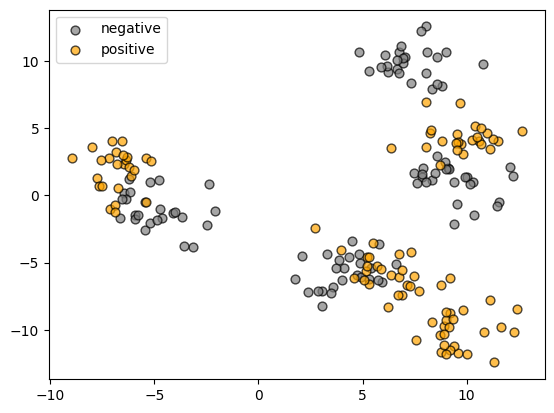

In [63]:
plt.figure()
plot_data_logistic_regression(X_mk8,y_train)

<font color = green>

###  Polynomial Features
</font>



In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

In [65]:
degree = 10
poly= PolynomialFeatures(degree=degree,include_bias=False) # default is True means to return the first feature of all 1 as for degree 0
X_train_poly= poly.fit_transform(X_mk8)

In [66]:
C = 0.01
clf = LogisticRegression(C=C).fit(X_train_poly, y_train)
accuracy = clf.score (X_train_poly, y_train)
# print("train accuracy= {:.3%}".format(accuracy))

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Call prediction for all grid values (precision of drawing = 0.05,
 you may configure to speed up e.g. precision=0.05)
Computing prediction completed.


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


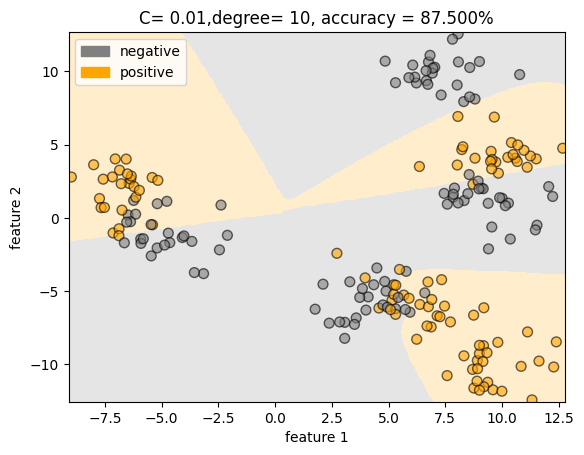

In [67]:
plt.figure()
ax = plt.gca()
plot_decision_boundary_poly(clf, X_train_poly, y_train, degree= degree, ax = ax, precision= 0.05, title = 'C= {},degree= {}, accuracy = {:.3%}'.format(C, degree, accuracy))


<font color = green>

## Muticlass classification

</font>

<font color = green>

### Load fruits data set

</font>

In [55]:
import os
cwd= os.getcwd() # current working directory
path = os.path.join(cwd,'data') 
fn=  os.path.join(path , 'fruit_data_with_colors.txt')
df_fruits = pd.read_table(fn) 
X = df_fruits[['width', 'height']].values
y = df_fruits['fruit_label'].values
df_fruits.head(20)
fruits_dict = dict(zip(df_fruits['fruit_label'].unique(), df_fruits['fruit_name'].unique()))
# fruits_dict

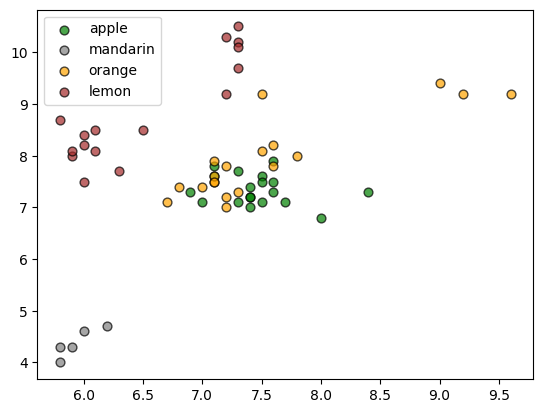

In [143]:
plt.figure() 
plot_multi_class_logistic_regression (X,y,dict_names=fruits_dict)

In [86]:
help(LogisticRegression)


Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

Accuracy=0.7288135593220338
Call prediction for all grid values (precision of drawing = 0.005,
 you may configure to speed up e.g. precision=0.05)


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


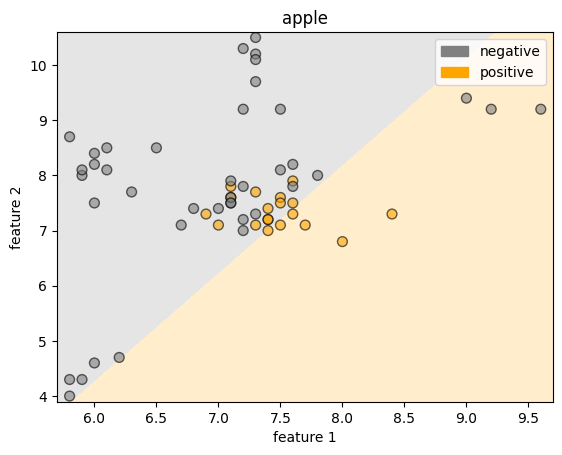

In [60]:
fruit_label = 1
y_one_vs_all = y==fruit_label
y_one_vs_all = y_one_vs_all.astype(int)

clf = LogisticRegression(C=1000).fit (X, y_one_vs_all)
print ('Accuracy={}'. format (clf.score(X,y_one_vs_all)))
plt.figure()
plot_decision_boundary(clf, X, y_one_vs_all, title=fruits_dict[fruit_label], precision = 0.005)


<font color = green>

### Sklearn multiclass classificcation

</font>

In [ ]:
print ('set(y) = {}'.format (set(y)))
print ('X.shape= {}\ny.shape = {}, '.format (X.shape, y.shape))
clf= LogisticRegression(C=1000, max_iter=2000).fit(X, y)
print ('Accuracy={}'. format (clf.score(X,y)))
clf.intercept_, clf.coef_

set(y) = {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
X.shape= (59, 2)
y.shape = (59,), 
Accuracy=0.847457627118644


(array([-31.66260266,  13.84518222, -43.7142823 ,  61.53170274]),
 array([[  9.1704323 ,  -3.67184196],
        [  7.08774589,  -9.19691307],
        [  6.84362365,   0.19592934],
        [-23.10180185,  12.67282569]]))

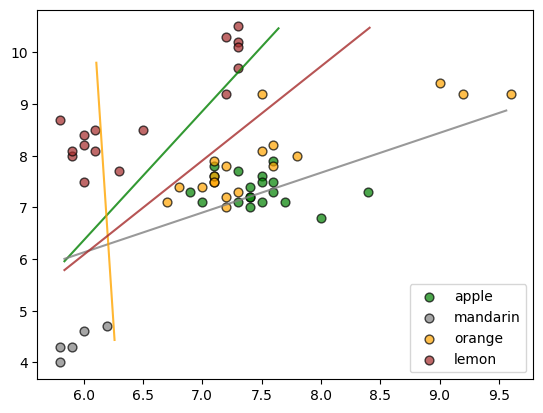

In [72]:
plt.figure() 
plot_multi_class_logistic_regression (X,y,dict_names=fruits_dict)
draw_linear_decision_boundaries_multiclass(clf,X)

<font color = green>

## Iris dataset

</font>

In [136]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y, labels = iris.data, iris.target, iris.target_names
print (labels)
clf= LogisticRegression(C=100, max_iter=2000).fit(X, y)
print ('Accuracy={}'. format (clf.score(X,y)))
clf.intercept_, clf.coef_

['setosa' 'versicolor' 'virginica']
Accuracy=0.98


(array([  1.9159118 ,  13.46070841, -15.37662021]),
 array([[ 2.50935285,  4.72836077, -6.73572747, -3.38760119],
        [-0.11239857, -0.23816484, -0.20063514, -4.32794113],
        [-2.39695428, -4.49019593,  6.93636261,  7.71554232]]))

Accuracy=0.8333333333333334
clf.intercept_=[ 25.20147502  -6.10573043 -19.09574459], 
clf.coef_=
[[-9.33492549  8.18440942]
 [ 3.72518968 -4.30410326]
 [ 5.60973581 -3.88030616]]


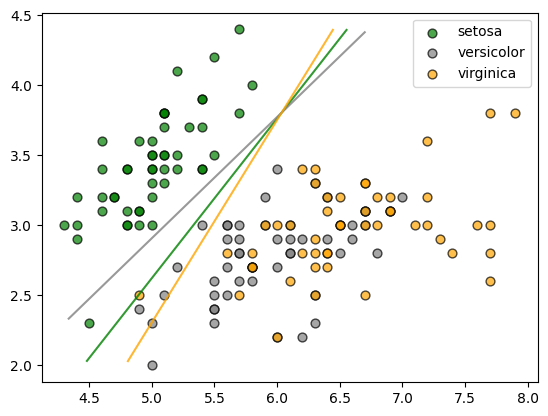

In [106]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
dict_names = {i:v for i,v in enumerate(labels)}

X2= X[:,:2]
clf= LogisticRegression(C=100).fit(X2, y)
print ('Accuracy={}'. format (clf.score(X2,y)))
print ('clf.intercept_={}, \nclf.coef_=\n{}'.format(clf.intercept_, clf.coef_))
plt.figure() 
plot_multi_class_logistic_regression (X2,y, dict_names = dict_names)
draw_linear_decision_boundaries_multiclass(clf,X2)